In [9]:
%matplotlib inline

from collections import defaultdict

import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras import backend as K
from keras.applications import ResNet50, VGG16
from keras.applications.vgg16 import WEIGHTS_PATH_NO_TOP
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.datasets import cifar10
from keras.engine.topology import Layer
from keras.layers import Input, Conv1D, Conv2D, PReLU, BatchNormalization, Add, LeakyReLU, Dense, Flatten, \
    GlobalAveragePooling2D, Dropout, Convolution2D, MaxPooling2D, Activation, Embedding, Reshape
from keras.layers.merge import Concatenate
from keras.losses import binary_crossentropy, mean_squared_error
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import conv_utils, to_categorical, get_file
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Read ICML2014 dataset

In [2]:
data = np.load('data/cullpdb+profile_6133.npy.gz')

In [3]:
data = data.reshape((data.shape[0], 700, 57))

In [4]:
n_train = 5600
n_test = 5877-5605
n_val = 6133-5877

x_train = data[:n_train,:,:22]
x_test = data[n_train:n_train+n_test,:,:22]
x_val = data[n_train+n_test:,:,:22]

y_train = data[:n_train,:,22:31]
y_test = data[n_train:n_train+n_test,:,22:31]
y_val = data[n_train+n_test:,:,22:31]

labels_amino_acids = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 
                      'Y', 'X', None]
labels_sec_structure = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T', None]

def one_hot_to_sequences(one_hot_vector, encoding):
    sequences = []
    for s in one_hot_vector:
        sequence = []
        for l in s:
            letter = encoding[np.where(l == 1)[0][0]]
            if letter is not None:
                sequence.append(letter)
        sequences.append(sequence)
    
    return sequences

x_train_sequences = one_hot_to_sequences(x_train, labels_amino_acids)
x_test_sequences = one_hot_to_sequences(x_test, labels_amino_acids)
x_val_sequences = one_hot_to_sequences(x_val, labels_amino_acids)

y_train_sequences = one_hot_to_sequences(y_train, labels_sec_structure)
y_test_sequences = one_hot_to_sequences(y_test, labels_sec_structure)
y_val_sequences = one_hot_to_sequences(y_val, labels_sec_structure)

In [63]:
def reduction_arr_8_to_3(mat):
    mat_new = np.zeros((mat.shape[0], mat.shape[1], 3))
    for i, seq in enumerate(mat):
        for j, state in enumerate(seq):
            new_state = 0
            state = np.argmax(state)
            if labels_sec_structure[state] in ('H', 'G'):
                new_state = 1
            elif labels_sec_structure[state] in ('E', 'B'):
                new_state = 2
            
            mat_new[i,j,new_state] = 1
    
    return mat_new

y_train_3 = reduction_arr_8_to_3(y_train)
y_test_3 = reduction_arr_8_to_3(y_test)
y_val_3 = reduction_arr_8_to_3(y_val)

In [51]:
x_train_int = np.argmax(x_train, axis=2)
x_test_int = np.argmax(x_test, axis=2)
x_val_int = np.argmax(x_val, axis=2)

# Read cb513 dataset

In [5]:
data_cb513 = np.load('data/cb513+profile_split1.npy.gz')

In [6]:
data_cb513.shape

(514, 39900)

In [7]:
data_cb513 = data_cb513.reshape((data_cb513.shape[0], 700, 57))
data_cb513.shape

(514, 700, 57)

In [8]:
n_train_cb513 = 400
n_test_cb513 = 60
n_val_cb513 = 54

x_train_cb513 = data_cb513[:n_train_cb513,:,:22]
x_test_cb513 = data_cb513[n_train_cb513:n_train_cb513+n_test_cb513,:,:22]
x_val_cb513 = data_cb513[n_train_cb513+n_test_cb513:,:,:22]

y_train_cb513 = data_cb513[:n_train_cb513,:,22:31]
y_test_cb513 = data_cb513[n_train_cb513:n_train_cb513+n_test_cb513,:,22:31]
y_val_cb513 = data_cb513[n_train_cb513+n_test_cb513:,:,22:31]

x_train_cb513_sequences = one_hot_to_sequences(x_train_cb513, labels_amino_acids)
x_test_cb513_sequences = one_hot_to_sequences(x_test_cb513, labels_amino_acids)
x_val_cb513_sequences = one_hot_to_sequences(x_val_cb513, labels_amino_acids)

y_train_cb513_sequences = one_hot_to_sequences(y_train_cb513, labels_sec_structure)
y_test_cb513_sequences = one_hot_to_sequences(y_test_cb513, labels_sec_structure)
y_val_cb513_sequences = one_hot_to_sequences(y_val_cb513, labels_sec_structure)

In [ ]:
x_train_cb513_int = np.argmax(x_train_cb513, axis=2)
x_val_cb513_int = np.argmax(x_val_cb513, axis=2)

# Model

In [21]:
x_input = Input(shape=(13, x_train.shape[2]))
x = Conv1D(filters=80, kernel_size=7, strides=1, padding='same')(x_input)
x = Conv1D(filters=80, kernel_size=9, strides=1, padding='same')(x)
x = Conv1D(filters=80, kernel_size=11, strides=1, padding='same')(x)
x = Flatten()(x)
x = Dense(9, activation='softmax')(x)
model = Model(x_input, x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 13, 22)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 13, 80)            12400     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 13, 80)            57680     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 13, 80)            70480     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1040)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 9369      
Total params: 149,929
Trainable params: 149,929
Non-trainable params: 0
_________________________________________________________________


In [11]:
def input_to_chunks(x, y, chunk_size):
    chunk_size_center = (chunk_size - 1) // 2

    x_chunked = np.zeros((x.shape[0] * x.shape[1] + chunk_size_center * 2 * x.shape[1], chunk_size, x.shape[2]))
    y_chunked = np.zeros((y.shape[0] * y.shape[1] + chunk_size_center * 2 * y.shape[1], y.shape[2]))

    seq = 0
    seq_chunked_position = 0
    with tqdm(total=x.shape[0]) as progress:
        while seq < x.shape[0]:
            last_seq_protein = 0
            for seq_protein in np.arange(0, 700):
                if x[seq, seq_protein, -1] == 1:
                    break

                last_seq_protein += 1

            for seq_protein in np.arange(0, last_seq_protein):
                for i, seq_protein_part in enumerate(np.arange(seq_protein - chunk_size_center,
                                                               seq_protein + chunk_size_center + 1)):
                    if seq_protein_part < 0 or seq_protein_part >= last_seq_protein:
                        x_chunked[seq_chunked_position + seq_protein, i] = np.zeros(x.shape[2])
                        x_chunked[seq_chunked_position + seq_protein, i, -1] = 1
                        continue

                    if seq_protein_part == 700:
                        print(seq, seq_protein_part, last_seq_protein)
                    x_chunked[seq_chunked_position + seq_protein, i] = x[seq, seq_protein_part, :]

                y_chunked[seq_chunked_position + seq_protein] = y[seq, seq_protein]

            seq_chunked_position += last_seq_protein
            seq += 1

            progress.update()
            
    x_chunked = x_chunked[:seq_chunked_position]
    y_chunked = y_chunked[:seq_chunked_position]

    return x_chunked, y_chunked

In [11]:
x_train_chunked, y_train_chunked = input_to_chunks(x_train, y_train, 13)

100%|██████████| 5600/5600 [00:31<00:00, 180.62it/s]


In [12]:
x_train_chunked, _, y_train_chunked, _ = train_test_split(x_train_chunked, y_train_chunked, test_size=0.0, 
                                                          random_state=42)

In [13]:
x_val_chunked, y_val_chunked = input_to_chunks(x_val, y_val, 13)

100%|██████████| 261/261 [00:01<00:00, 181.98it/s]


In [14]:
x_train_chunked.shape, y_train_chunked.shape

((1168149, 13, 22), (1168149, 9))

In [29]:
model.fit(x_train_chunked, y_train_chunked, batch_size=256, epochs=10, validation_data=(x_val_chunked, y_val_chunked))

Train on 1168149 samples, validate on 54193 samples
Epoch 1/10
1168149/1168149 [==============================] - 42s 36us/step - loss: 1.3442 - acc: 0.4962 - val_loss: 1.3473 - val_acc: 0.4936
Epoch 2/10
1168149/1168149 [==============================] - 42s 36us/step - loss: 1.3437 - acc: 0.4970 - val_loss: 1.3464 - val_acc: 0.4936
Epoch 3/10
1168149/1168149 [==============================] - 42s 36us/step - loss: 1.3433 - acc: 0.4971 - val_loss: 1.3483 - val_acc: 0.4933
Epoch 4/10
1168149/1168149 [==============================] - 42s 36us/step - loss: 1.3431 - acc: 0.4969 - val_loss: 1.3460 - val_acc: 0.4932
Epoch 5/10
1168149/1168149 [==============================] - 42s 36us/step - loss: 1.3428 - acc: 0.4967 - val_loss: 1.3488 - val_acc: 0.4917
Epoch 6/10
1168149/1168149 [==============================] - 42s 36us/step - loss: 1.3428 - acc: 0.4970 - val_loss: 1.3457 - val_acc: 0.4929
Epoch 7/10
1168149/1168149 [==============================] - 42s 36us/step - loss: 1.3426 - acc

## Model 2 - residual connections 

In [76]:
x_input = Input(shape=(13, x_train.shape[2]))
conv1d_1 = Conv1D(filters=22, kernel_size=7, strides=1, padding='same', activation='relu')(x_input)
add_1 = Add()([x_input, conv1d_1])
conv1d_2 = Conv1D(filters=22, kernel_size=9, strides=1, padding='same', activation='relu')(add_1)
add_2 = Add()([add_1, conv1d_2])
conv1d_3 = Conv1D(filters=22, kernel_size=11, strides=1, padding='same', activation='relu')(add_2)
add_3 = Add()([add_2, conv1d_3])
flatten = Flatten()(add_3)
dense = Dense(9, activation='softmax')(flatten)
model = Model(x_input, dense)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 13, 22)       0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 13, 22)       3410        input_13[0][0]                   
__________________________________________________________________________________________________
add_23 (Add)                    (None, 13, 22)       0           input_13[0][0]                   
                                                                 conv1d_34[0][0]                  
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 13, 22)       4378        add_23[0][0]                     
__________

In [77]:
model.fit(x_train_chunked, y_train_chunked, batch_size=256, epochs=10, validation_data=(x_val_chunked, y_val_chunked))

Train on 1168149 samples, validate on 54193 samples
Epoch 1/10
1168149/1168149 [==============================] - 30s 26us/step - loss: 1.2590 - acc: 0.5381 - val_loss: 1.2268 - val_acc: 0.5506
Epoch 2/10
1168149/1168149 [==============================] - 30s 26us/step - loss: 1.2070 - acc: 0.5588 - val_loss: 1.2116 - val_acc: 0.5544
Epoch 3/10
1168149/1168149 [==============================] - 30s 26us/step - loss: 1.1945 - acc: 0.5636 - val_loss: 1.2045 - val_acc: 0.5588
Epoch 4/10
 958464/1168149 [=======================>......] - ETA: 5s - loss: 1.1879 - acc: 0.5660

KeyboardInterrupt: 

### Test on cb513

In [62]:
x_train_cb513_chunked, y_train_cb513_chunked = input_to_chunks(x_train_cb513, y_train_cb513, 13)
x_train_cb513_chunked, _, y_train_cb513_chunked, _ = train_test_split(x_train_cb513_chunked, y_train_cb513_chunked, 
                                                                      test_size=0.0, random_state=42)

100%|██████████| 400/400 [00:01<00:00, 247.76it/s]


In [61]:
x_val_cb513_chunked, y_val_cb513_chunked = input_to_chunks(x_val_cb513, y_val_cb513, 13)

100%|██████████| 54/54 [00:00<00:00, 184.52it/s]


In [75]:
model.fit(x_train_cb513_chunked, y_train_cb513_chunked, batch_size=256, epochs=10, 
          validation_data=(x_val_cb513_chunked, y_val_cb513_chunked))

Train on 64049 samples, validate on 11604 samples
Epoch 1/10
64049/64049 [==============================] - 2s 35us/step - loss: 1.4772 - acc: 0.4428 - val_loss: 1.4380 - val_acc: 0.4559
Epoch 2/10
64049/64049 [==============================] - 2s 26us/step - loss: 1.3917 - acc: 0.4771 - val_loss: 1.4246 - val_acc: 0.4666
Epoch 3/10
64049/64049 [==============================] - 2s 26us/step - loss: 1.3869 - acc: 0.4799 - val_loss: 1.4379 - val_acc: 0.4564
Epoch 4/10
64049/64049 [==============================] - 2s 26us/step - loss: 1.3848 - acc: 0.4792 - val_loss: 1.4322 - val_acc: 0.4607
Epoch 5/10
64049/64049 [==============================] - 2s 26us/step - loss: 1.3826 - acc: 0.4806 - val_loss: 1.4367 - val_acc: 0.4592
Epoch 6/10
64049/64049 [==============================] - 2s 26us/step - loss: 1.3827 - acc: 0.4805 - val_loss: 1.4294 - val_acc: 0.4624
Epoch 7/10
64049/64049 [==============================] - 2s 26us/step - loss: 1.3816 - acc: 0.4809 - val_loss: 1.4295 - val_acc

## Train model using original data (non-chunked)

In [81]:
x_input = Input(shape=(700, x_train.shape[2]))
conv1d_1 = Conv1D(filters=9, kernel_size=7, strides=1, padding='same', activation='relu')(x_input)
# add_1 = Add()([x_input, conv1d_1])
conv1d_2 = Conv1D(filters=9, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
add_2 = Add()([conv1d_1, conv1d_2])
conv1d_3 = Conv1D(filters=9, kernel_size=11, strides=1, padding='same', activation='relu')(add_2)
add_3 = Add()([add_2, conv1d_3])
model = Model(x_input, add_3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 700, 22)      0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 700, 9)       1395        input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 700, 9)       738         conv1d_40[0][0]                  
__________________________________________________________________________________________________
add_28 (Add)                    (None, 700, 9)       0           conv1d_40[0][0]                  
                                                                 conv1d_41[0][0]                  
__________

In [82]:
results = model.fit(x_train, y_train, batch_size=256, epochs=500, validation_data=(x_val, y_val))

Train on 5600 samples, validate on 261 samples
Epoch 1/500
5600/5600 [==============================] - 2s 345us/step - loss: 2.1582 - acc: 0.0505 - val_loss: 1.5668 - val_acc: 0.7497
Epoch 2/500
5600/5600 [==============================] - 1s 243us/step - loss: 1.2848 - acc: 0.7616 - val_loss: 1.0821 - val_acc: 0.7713
Epoch 3/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.9656 - acc: 0.7776 - val_loss: 0.8409 - val_acc: 0.7828
Epoch 4/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.7461 - acc: 0.7875 - val_loss: 0.6344 - val_acc: 0.7905
Epoch 5/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.5687 - acc: 0.7938 - val_loss: 0.5441 - val_acc: 0.7938
Epoch 6/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.5420 - acc: 0.7970 - val_loss: 0.5360 - val_acc: 0.7966
Epoch 7/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.5344 - acc: 0.7989 - val_loss: 0.5297 - val_acc: 0

5600/5600 [==============================] - 1s 242us/step - loss: 0.4490 - acc: 0.8314 - val_loss: 0.4489 - val_acc: 0.8298
Epoch 61/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.4480 - acc: 0.8316 - val_loss: 0.4475 - val_acc: 0.8306
Epoch 62/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.4462 - acc: 0.8324 - val_loss: 0.4458 - val_acc: 0.8311
Epoch 63/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.4447 - acc: 0.8328 - val_loss: 0.4444 - val_acc: 0.8318
Epoch 64/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.4434 - acc: 0.8335 - val_loss: 0.4434 - val_acc: 0.8322
Epoch 65/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.4424 - acc: 0.8339 - val_loss: 0.4425 - val_acc: 0.8326
Epoch 66/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.4414 - acc: 0.8342 - val_loss: 0.4411 - val_acc: 0.8329
Epoch 67/500
5600/5600 [=======================

5600/5600 [==============================] - 1s 243us/step - loss: 0.4070 - acc: 0.8501 - val_loss: 0.4074 - val_acc: 0.8490
Epoch 179/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.4068 - acc: 0.8501 - val_loss: 0.4072 - val_acc: 0.8490
Epoch 180/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.4066 - acc: 0.8502 - val_loss: 0.4069 - val_acc: 0.8490
Epoch 181/500
5600/5600 [==============================] - 1s 243us/step - loss: 0.4066 - acc: 0.8502 - val_loss: 0.4068 - val_acc: 0.8492
Epoch 182/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.4062 - acc: 0.8504 - val_loss: 0.4069 - val_acc: 0.8491
Epoch 183/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.4061 - acc: 0.8505 - val_loss: 0.4067 - val_acc: 0.8493
Epoch 184/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.4058 - acc: 0.8505 - val_loss: 0.4065 - val_acc: 0.8491
Epoch 185/500
5600/5600 [================

5600/5600 [==============================] - 1s 242us/step - loss: 0.3896 - acc: 0.8591 - val_loss: 0.3899 - val_acc: 0.8578
Epoch 238/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3894 - acc: 0.8592 - val_loss: 0.3897 - val_acc: 0.8579
Epoch 239/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3891 - acc: 0.8594 - val_loss: 0.3892 - val_acc: 0.8581
Epoch 240/500
5600/5600 [==============================] - 1s 243us/step - loss: 0.3893 - acc: 0.8591 - val_loss: 0.3890 - val_acc: 0.8582
Epoch 241/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3887 - acc: 0.8593 - val_loss: 0.3889 - val_acc: 0.8583
Epoch 242/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.3885 - acc: 0.8597 - val_loss: 0.3892 - val_acc: 0.8585
Epoch 243/500
5600/5600 [==============================] - 1s 243us/step - loss: 0.3888 - acc: 0.8594 - val_loss: 0.3883 - val_acc: 0.8587
Epoch 244/500
5600/5600 [================

5600/5600 [==============================] - 1s 242us/step - loss: 0.3828 - acc: 0.8614 - val_loss: 0.3835 - val_acc: 0.8601
Epoch 297/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3826 - acc: 0.8614 - val_loss: 0.3833 - val_acc: 0.8604
Epoch 298/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.3825 - acc: 0.8616 - val_loss: 0.3832 - val_acc: 0.8605
Epoch 299/500
5600/5600 [==============================] - 1s 243us/step - loss: 0.3824 - acc: 0.8616 - val_loss: 0.3831 - val_acc: 0.8608
Epoch 300/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3825 - acc: 0.8616 - val_loss: 0.3832 - val_acc: 0.8601
Epoch 301/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3824 - acc: 0.8616 - val_loss: 0.3831 - val_acc: 0.8601
Epoch 302/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3821 - acc: 0.8617 - val_loss: 0.3828 - val_acc: 0.8604
Epoch 303/500
5600/5600 [================

5600/5600 [==============================] - 1s 243us/step - loss: 0.3786 - acc: 0.8632 - val_loss: 0.3786 - val_acc: 0.8620
Epoch 356/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3779 - acc: 0.8634 - val_loss: 0.3787 - val_acc: 0.8617
Epoch 357/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3780 - acc: 0.8633 - val_loss: 0.3786 - val_acc: 0.8625
Epoch 358/500
5600/5600 [==============================] - 1s 243us/step - loss: 0.3779 - acc: 0.8636 - val_loss: 0.3786 - val_acc: 0.8624
Epoch 359/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3778 - acc: 0.8635 - val_loss: 0.3786 - val_acc: 0.8619
Epoch 360/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3776 - acc: 0.8635 - val_loss: 0.3782 - val_acc: 0.8622
Epoch 361/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3773 - acc: 0.8636 - val_loss: 0.3799 - val_acc: 0.8625
Epoch 362/500
5600/5600 [================

5600/5600 [==============================] - 1s 241us/step - loss: 0.3738 - acc: 0.8648 - val_loss: 0.3752 - val_acc: 0.8629
Epoch 415/500
5600/5600 [==============================] - 1s 243us/step - loss: 0.3738 - acc: 0.8649 - val_loss: 0.3755 - val_acc: 0.8622
Epoch 416/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.3739 - acc: 0.8648 - val_loss: 0.3749 - val_acc: 0.8634
Epoch 417/500
5600/5600 [==============================] - 1s 239us/step - loss: 0.3738 - acc: 0.8649 - val_loss: 0.3796 - val_acc: 0.8632
Epoch 418/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.3799 - acc: 0.8625 - val_loss: 0.3789 - val_acc: 0.8615
Epoch 419/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3766 - acc: 0.8636 - val_loss: 0.3769 - val_acc: 0.8618
Epoch 420/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3751 - acc: 0.8641 - val_loss: 0.3761 - val_acc: 0.8626
Epoch 421/500
5600/5600 [================

5600/5600 [==============================] - 1s 242us/step - loss: 0.3718 - acc: 0.8655 - val_loss: 0.3732 - val_acc: 0.8637
Epoch 474/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3714 - acc: 0.8656 - val_loss: 0.3731 - val_acc: 0.8632
Epoch 475/500
5600/5600 [==============================] - 1s 241us/step - loss: 0.3713 - acc: 0.8656 - val_loss: 0.3730 - val_acc: 0.8640
Epoch 476/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3713 - acc: 0.8657 - val_loss: 0.3730 - val_acc: 0.8634
Epoch 477/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.3711 - acc: 0.8658 - val_loss: 0.3729 - val_acc: 0.8637
Epoch 478/500
5600/5600 [==============================] - 1s 242us/step - loss: 0.3711 - acc: 0.8658 - val_loss: 0.3728 - val_acc: 0.8640
Epoch 479/500
5600/5600 [==============================] - 1s 240us/step - loss: 0.3710 - acc: 0.8658 - val_loss: 0.3732 - val_acc: 0.8634
Epoch 480/500
5600/5600 [================

## With an additional embedding layer 

In [24]:
x_input = Input(shape=(700,))
embed = Embedding(22, 9)(x_input)
conv1d_1 = Conv1D(filters=9, kernel_size=7, strides=1, padding='same', activation='relu')(embed)
# add_1 = Add()([x_input, conv1d_1])
conv1d_2 = Conv1D(filters=9, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
add_2 = Add()([conv1d_1, conv1d_2])
conv1d_3 = Conv1D(filters=9, kernel_size=11, strides=1, padding='same', activation='relu')(add_2)
add_3 = Add()([add_2, conv1d_3])
model = Model(x_input, add_3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 700)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 700, 9)       198         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 700, 9)       576         embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 700, 9)       738         conv1d_4[0][0]                   
__________________________________________________________________________________________________
add_3 (Add

In [25]:
# results = model.fit(x_train_cb513_int, y_train_cb513, batch_size=256, epochs=100, 
#                     validation_data=(x_val_cb513_int, y_val_cb513))

results = model.fit(x_train_int, y_train, batch_size=256, epochs=150, 
                    validation_data=(x_val_int, y_val))

Train on 5600 samples, validate on 261 samples
Epoch 1/100
5600/5600 [==============================] - 1s 197us/step - loss: 1.3227 - acc: 0.6399 - val_loss: 0.7480 - val_acc: 0.7807
Epoch 2/100
5600/5600 [==============================] - 1s 137us/step - loss: 0.6343 - acc: 0.7857 - val_loss: 0.5477 - val_acc: 0.7911
Epoch 3/100
5600/5600 [==============================] - 1s 135us/step - loss: 0.5378 - acc: 0.7941 - val_loss: 0.5278 - val_acc: 0.7970
Epoch 4/100
5600/5600 [==============================] - 1s 134us/step - loss: 0.5263 - acc: 0.7993 - val_loss: 0.5230 - val_acc: 0.8003
Epoch 5/100
5600/5600 [==============================] - 1s 133us/step - loss: 0.5201 - acc: 0.8018 - val_loss: 0.5159 - val_acc: 0.8012
Epoch 6/100
5600/5600 [==============================] - 1s 132us/step - loss: 0.5143 - acc: 0.8031 - val_loss: 0.5116 - val_acc: 0.8022
Epoch 7/100
5600/5600 [==============================] - 1s 132us/step - loss: 0.5107 - acc: 0.8041 - val_loss: 0.5088 - val_acc: 0

5600/5600 [==============================] - 1s 126us/step - loss: 0.4272 - acc: 0.8415 - val_loss: 0.4274 - val_acc: 0.8402
Epoch 61/100
5600/5600 [==============================] - 1s 127us/step - loss: 0.4266 - acc: 0.8415 - val_loss: 0.4259 - val_acc: 0.8406
Epoch 62/100
5600/5600 [==============================] - 1s 127us/step - loss: 0.4257 - acc: 0.8418 - val_loss: 0.4255 - val_acc: 0.8405
Epoch 63/100
5600/5600 [==============================] - 1s 126us/step - loss: 0.4248 - acc: 0.8421 - val_loss: 0.4251 - val_acc: 0.8405
Epoch 64/100
5600/5600 [==============================] - 1s 126us/step - loss: 0.4242 - acc: 0.8424 - val_loss: 0.4245 - val_acc: 0.8408
Epoch 65/100
5600/5600 [==============================] - 1s 127us/step - loss: 0.4237 - acc: 0.8425 - val_loss: 0.4239 - val_acc: 0.8412
Epoch 66/100
5600/5600 [==============================] - 1s 125us/step - loss: 0.4230 - acc: 0.8427 - val_loss: 0.4232 - val_acc: 0.8417
Epoch 67/100
5600/5600 [=======================

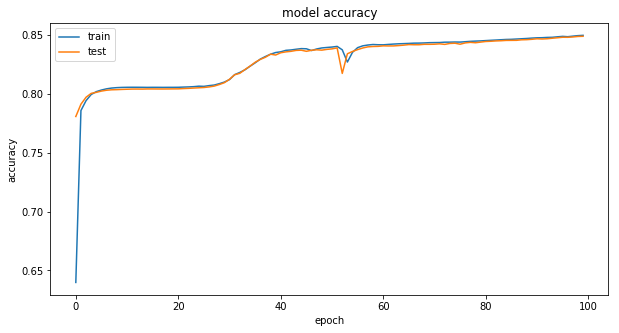

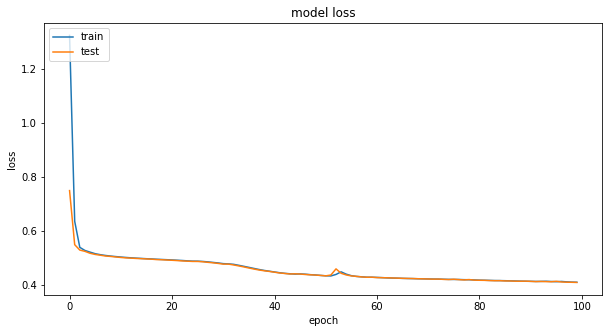

In [33]:
plt.figure(figsize=(10,5))
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Additional embedding layer makes the training much faster :) 

# Multi-model test

In [67]:
def model_simple(output_size=9): 
    x_input = Input(shape=(700, 22))
    conv1d_1 = Conv1D(filters=output_size, kernel_size=7, strides=1, padding='same', activation='relu')(x_input)
    model = Model(x_input, conv1d_1)
    
    return model

def model_deep(output_size): 
    x_input = Input(shape=(700, 22))
    conv1d_1 = Conv1D(filters=output_size, kernel_size=7, strides=1, padding='same', activation='relu')(x_input)
    conv1d_2 = Conv1D(filters=output_size, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
    conv1d_3 = Conv1D(filters=output_size, kernel_size=11, strides=1, padding='same', activation='relu')(conv1d_2)
    model = Model(x_input, conv1d_3)
    
    return model

def model_deep_resnet(output_size): 
    x_input = Input(shape=(700, 22))
    conv1d_1 = Conv1D(filters=output_size, kernel_size=7, strides=1, padding='same', activation='relu')(x_input)
    conv1d_2 = Conv1D(filters=output_size, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
    add_2 = Add()([conv1d_1, conv1d_2])
    conv1d_3 = Conv1D(filters=output_size, kernel_size=11, strides=1, padding='same', activation='relu')(add_2)
    add_3 = Add()([add_2, conv1d_3])
    model = Model(x_input, add_3)
    
    return model

def model_deep_embedded(output_size): 
    x_input = Input(shape=(700,))
    embed = Embedding(22, 22)(x_input)
    conv1d_1 = Conv1D(filters=22, kernel_size=7, strides=1, padding='same', activation='relu')(embed)
    conv1d_2 = Conv1D(filters=22, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
    conv1d_3 = Conv1D(filters=output_size, kernel_size=11, strides=1, padding='same', activation='relu')(conv1d_2)
    model = Model(x_input, conv1d_3)
    
    return model

def model_deep_resnet_embedded(output_size): 
    x_input = Input(shape=(700,))
    embed = Embedding(22, 9)(x_input)
    conv1d_1 = Conv1D(filters=output_size, kernel_size=7, strides=1, padding='same', activation='relu')(embed)
    conv1d_2 = Conv1D(filters=output_size, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
    add_2 = Add()([conv1d_1, conv1d_2])
    conv1d_3 = Conv1D(filters=output_size, kernel_size=11, strides=1, padding='same', activation='relu')(add_2)
    add_3 = Add()([add_2, conv1d_3])
    model = Model(x_input, add_3)
    
    return model

models = {
    'simple': (model_simple, 'default'),
    'deep': (model_deep, 'default'),
    'deep_resnet': (model_deep_resnet, 'default'),
    'deep_embedded': (model_deep_embedded, 'int'),
    'deep_resnet_embedded': (model_deep_resnet_embedded, 'int')
}

In [45]:
models_results = {}
models_instances = {}
for model_name, (model_fn, model_input_type) in models.items():
    print('--------------------------------------------------------------------')
    print('--- Training model: %s ---' % model_name)
    print('--------------------------------------------------------------------')
    
    model = model_fn()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    _xt = x_train_int if model_input_type == 'int' else x_train
    _xv = x_val_int if model_input_type == 'int' else x_val
    
    models_results[model_name] = model.fit(_xt, y_train, batch_size=256, epochs=150, 
                                           validation_data=(_xv, y_val))
    models_instances[model_name] = model

--------------------------------------------------------------------
--- Training model: deep_embedded ---
--------------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 700)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 700, 22)           484       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 700, 22)           3410      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 700, 22)           4378      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 700, 9)            2187      
Total params: 10,459
Trainable params: 10,459
Non-trainable params: 0
____________________________

Epoch 52/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.4166 - acc: 0.8466 - val_loss: 0.4183 - val_acc: 0.8454
Epoch 53/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.4184 - acc: 0.8472 - val_loss: 0.4219 - val_acc: 0.8455
Epoch 54/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.4197 - acc: 0.8468 - val_loss: 0.4182 - val_acc: 0.8468
Epoch 55/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.4161 - acc: 0.8473 - val_loss: 0.4150 - val_acc: 0.8469
Epoch 56/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.4157 - acc: 0.8490 - val_loss: 0.4264 - val_acc: 0.8474
Epoch 57/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.4232 - acc: 0.8489 - val_loss: 0.4169 - val_acc: 0.8467
Epoch 58/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.4215 - acc: 0.8462 - val_loss: 0.4267 - val_acc: 0.8423
Epoch 59/150
5600/5600 [==========

5600/5600 [==============================] - 1s 173us/step - loss: 0.3969 - acc: 0.8570 - val_loss: 0.3961 - val_acc: 0.8568
Epoch 112/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.3935 - acc: 0.8584 - val_loss: 0.3987 - val_acc: 0.8571
Epoch 113/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.4048 - acc: 0.8574 - val_loss: 0.4062 - val_acc: 0.8563
Epoch 114/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.4033 - acc: 0.8579 - val_loss: 0.4017 - val_acc: 0.8569
Epoch 115/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3979 - acc: 0.8583 - val_loss: 0.3942 - val_acc: 0.8577
Epoch 116/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.3922 - acc: 0.8590 - val_loss: 0.3914 - val_acc: 0.8581
Epoch 117/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3905 - acc: 0.8596 - val_loss: 0.3912 - val_acc: 0.8580
Epoch 118/150
5600/5600 [================

Epoch 4/150
5600/5600 [==============================] - 1s 132us/step - loss: 0.5360 - acc: 0.7992 - val_loss: 0.5279 - val_acc: 0.7992
Epoch 5/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.5257 - acc: 0.8018 - val_loss: 0.5200 - val_acc: 0.8011
Epoch 6/150
5600/5600 [==============================] - 1s 132us/step - loss: 0.5192 - acc: 0.8028 - val_loss: 0.5151 - val_acc: 0.8018
Epoch 7/150
5600/5600 [==============================] - 1s 132us/step - loss: 0.5140 - acc: 0.8032 - val_loss: 0.5103 - val_acc: 0.8020
Epoch 8/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.5100 - acc: 0.8035 - val_loss: 0.5067 - val_acc: 0.8023
Epoch 9/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.5073 - acc: 0.8038 - val_loss: 0.5046 - val_acc: 0.8027
Epoch 10/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.5055 - acc: 0.8038 - val_loss: 0.5055 - val_acc: 0.8025
Epoch 11/150
5600/5600 [================

5600/5600 [==============================] - 1s 133us/step - loss: 0.4238 - acc: 0.8440 - val_loss: 0.4229 - val_acc: 0.8434
Epoch 64/150
5600/5600 [==============================] - 1s 132us/step - loss: 0.4222 - acc: 0.8439 - val_loss: 0.4210 - val_acc: 0.8432
Epoch 65/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.4212 - acc: 0.8445 - val_loss: 0.4204 - val_acc: 0.8436
Epoch 66/150
5600/5600 [==============================] - 1s 132us/step - loss: 0.4220 - acc: 0.8438 - val_loss: 0.4210 - val_acc: 0.8430
Epoch 67/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.4221 - acc: 0.8445 - val_loss: 0.4193 - val_acc: 0.8442
Epoch 68/150
5600/5600 [==============================] - 1s 132us/step - loss: 0.4219 - acc: 0.8444 - val_loss: 0.4232 - val_acc: 0.8431
Epoch 69/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.4215 - acc: 0.8447 - val_loss: 0.4190 - val_acc: 0.8443
Epoch 70/150
5600/5600 [=======================

5600/5600 [==============================] - 1s 133us/step - loss: 0.4051 - acc: 0.8526 - val_loss: 0.4314 - val_acc: 0.8461
Epoch 123/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.4306 - acc: 0.8452 - val_loss: 0.4203 - val_acc: 0.8530
Epoch 124/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.4121 - acc: 0.8545 - val_loss: 0.4051 - val_acc: 0.8553
Epoch 125/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.4025 - acc: 0.8556 - val_loss: 0.3991 - val_acc: 0.8558
Epoch 126/150
5600/5600 [==============================] - 1s 132us/step - loss: 0.3986 - acc: 0.8563 - val_loss: 0.3961 - val_acc: 0.8564
Epoch 127/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.3966 - acc: 0.8567 - val_loss: 0.3948 - val_acc: 0.8563
Epoch 128/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.3952 - acc: 0.8572 - val_loss: 0.3937 - val_acc: 0.8571
Epoch 129/150
5600/5600 [================

In [57]:
for model_name, model_instance in models_instances.items():
    _xt = x_test_int if models[model_name][1] == 'int' else x_test
    print('%s: %s' % (model_name, model_instance.evaluate(_xt, y_test)))

272/272 [==============================] - 0s 174us/step
simple: [0.4199063041630913, 0.8408928548588472]
272/272 [==============================] - 0s 198us/step
deep: [0.43307806113187003, 0.833356103476356]
272/272 [==============================] - 0s 183us/step
deep_resnet: [0.4056295314255883, 0.8496270986164317]
272/272 [==============================] - 0s 191us/step
deep_embedded: [0.37746155963224526, 0.8643802474526798]
272/272 [==============================] - 0s 129us/step
deep_resnet_embedded: [0.38261879016371336, 0.8614548339563257]


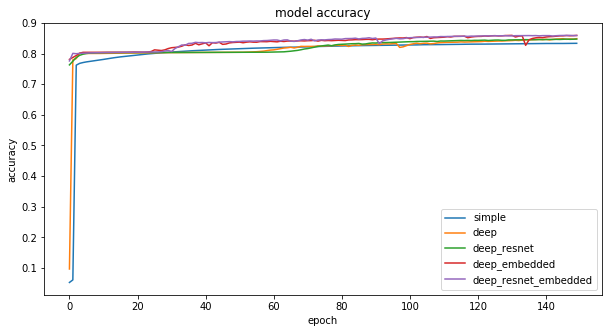

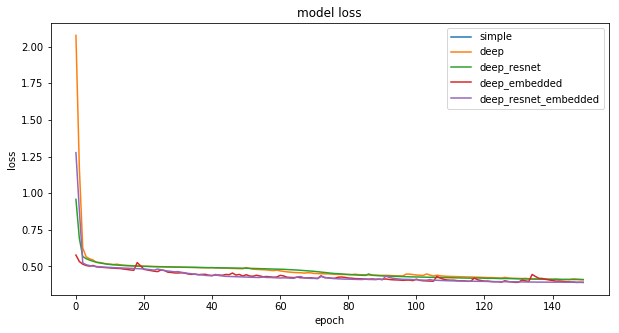

In [58]:
plt.figure(figsize=(10,5))
for model_name, model_results in models_results.items():
#     plt.plot(model_results.history['acc'])
    plt.plot(model_results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([n for n, _ in models_results.items()], loc='lower right')
plt.savefig('data/models_fig_val_acc.png')
plt.show()

plt.figure(figsize=(10,5))
for model_name, model_results in models_results.items():
#     plt.plot(model_results.history['loss'])
    plt.plot(model_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([n for n, _ in models_results.items()], loc='upper right')
plt.savefig('data/models_fig_val_loss.png')
plt.show()

### Same test on 3class

In [68]:
models_results = {}
models_instances = {}
for model_name, (model_fn, model_input_type) in models.items():
    print('--------------------------------------------------------------------')
    print('--- Training model: %s ---' % model_name)
    print('--------------------------------------------------------------------')
    
    model = model_fn(3)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    _xt = x_train_int if model_input_type == 'int' else x_train
    _xv = x_val_int if model_input_type == 'int' else x_val
    
    models_results[model_name] = model.fit(_xt, y_train_3, batch_size=256, epochs=150, 
                                           validation_data=(_xv, y_val_3))
    models_instances[model_name] = model

--------------------------------------------------------------------
--- Training model: simple ---
--------------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 700, 22)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 700, 3)            465       
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________
Train on 5600 samples, validate on 261 samples
Epoch 1/150
5600/5600 [==============================] - 2s 274us/step - loss: nan - acc: 0.8126 - val_loss: nan - val_acc: 0.8164
Epoch 2/150
5600/5600 [==============================] - 1s 134us/step - loss: nan - acc: 0.8167 - val_loss: nan - val_acc: 0.8187
Epoch 3/150
5600/5600 [==============================] - 1s 14

Epoch 55/150
5600/5600 [==============================] - 1s 134us/step - loss: 0.2841 - acc: 0.8696 - val_loss: 0.2836 - val_acc: 0.8693
Epoch 56/150
5600/5600 [==============================] - 1s 135us/step - loss: 0.2836 - acc: 0.8700 - val_loss: 0.2831 - val_acc: 0.8696
Epoch 57/150
5600/5600 [==============================] - 1s 134us/step - loss: 0.2831 - acc: 0.8703 - val_loss: 0.2829 - val_acc: 0.8699
Epoch 58/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.2827 - acc: 0.8706 - val_loss: 0.2825 - val_acc: 0.8703
Epoch 59/150
5600/5600 [==============================] - 1s 134us/step - loss: 0.2824 - acc: 0.8710 - val_loss: 0.2820 - val_acc: 0.8707
Epoch 60/150
5600/5600 [==============================] - 1s 135us/step - loss: 0.2820 - acc: 0.8713 - val_loss: 0.2816 - val_acc: 0.8709
Epoch 61/150
5600/5600 [==============================] - 1s 134us/step - loss: 0.2816 - acc: 0.8716 - val_loss: 0.2812 - val_acc: 0.8713
Epoch 62/150
5600/5600 [==========

5600/5600 [==============================] - 1s 134us/step - loss: 0.2700 - acc: 0.8770 - val_loss: 0.2694 - val_acc: 0.8773
Epoch 115/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.2698 - acc: 0.8773 - val_loss: 0.2694 - val_acc: 0.8776
Epoch 116/150
5600/5600 [==============================] - 1s 133us/step - loss: 0.2696 - acc: 0.8775 - val_loss: 0.2691 - val_acc: 0.8777
Epoch 117/150
5600/5600 [==============================] - 1s 134us/step - loss: 0.2695 - acc: 0.8776 - val_loss: 0.2692 - val_acc: 0.8778
Epoch 118/150
5600/5600 [==============================] - 1s 134us/step - loss: 0.2694 - acc: 0.8777 - val_loss: 0.2691 - val_acc: 0.8779
Epoch 119/150
5600/5600 [==============================] - 1s 134us/step - loss: 0.2692 - acc: 0.8778 - val_loss: 0.2688 - val_acc: 0.8782
Epoch 120/150
5600/5600 [==============================] - 1s 135us/step - loss: 0.2692 - acc: 0.8779 - val_loss: 0.2689 - val_acc: 0.8781
Epoch 121/150
5600/5600 [================

5600/5600 [==============================] - 1s 172us/step - loss: nan - acc: 0.8145 - val_loss: nan - val_acc: 0.8153
Epoch 17/150
5600/5600 [==============================] - 1s 173us/step - loss: nan - acc: 0.8147 - val_loss: nan - val_acc: 0.8155
Epoch 18/150
5600/5600 [==============================] - 1s 172us/step - loss: nan - acc: 0.8149 - val_loss: nan - val_acc: 0.8157
Epoch 19/150
5600/5600 [==============================] - 1s 174us/step - loss: nan - acc: 0.8150 - val_loss: 0.3403 - val_acc: 0.8155
Epoch 20/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3397 - acc: 0.8144 - val_loss: 0.3377 - val_acc: 0.8148
Epoch 21/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3382 - acc: 0.8139 - val_loss: 0.3367 - val_acc: 0.8149
Epoch 22/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3371 - acc: 0.8142 - val_loss: 0.3356 - val_acc: 0.8152
Epoch 23/150
5600/5600 [==============================] - 1s 171us/s

5600/5600 [==============================] - 1s 171us/step - loss: 0.3232 - acc: 0.8192 - val_loss: 0.3229 - val_acc: 0.8189
Epoch 76/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3231 - acc: 0.8192 - val_loss: 0.3228 - val_acc: 0.8191
Epoch 77/150
5600/5600 [==============================] - 1s 171us/step - loss: 0.3230 - acc: 0.8193 - val_loss: 0.3227 - val_acc: 0.8192
Epoch 78/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3229 - acc: 0.8193 - val_loss: 0.3226 - val_acc: 0.8193
Epoch 79/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3228 - acc: 0.8194 - val_loss: 0.3225 - val_acc: 0.8193
Epoch 80/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3227 - acc: 0.8195 - val_loss: 0.3222 - val_acc: 0.8195
Epoch 81/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.3226 - acc: 0.8196 - val_loss: 0.3221 - val_acc: 0.8196
Epoch 82/150
5600/5600 [=======================

5600/5600 [==============================] - 1s 171us/step - loss: 0.3179 - acc: 0.8264 - val_loss: 0.3174 - val_acc: 0.8266
Epoch 135/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3178 - acc: 0.8266 - val_loss: 0.3173 - val_acc: 0.8269
Epoch 136/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3177 - acc: 0.8268 - val_loss: 0.3171 - val_acc: 0.8270
Epoch 137/150
5600/5600 [==============================] - 1s 171us/step - loss: 0.3176 - acc: 0.8271 - val_loss: 0.3170 - val_acc: 0.8273
Epoch 138/150
5600/5600 [==============================] - 1s 170us/step - loss: 0.3175 - acc: 0.8273 - val_loss: 0.3169 - val_acc: 0.8274
Epoch 139/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3173 - acc: 0.8275 - val_loss: 0.3168 - val_acc: 0.8276
Epoch 140/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.3172 - acc: 0.8278 - val_loss: 0.3167 - val_acc: 0.8278
Epoch 141/150
5600/5600 [================

5600/5600 [==============================] - 1s 172us/step - loss: 0.3007 - acc: 0.8566 - val_loss: 0.3003 - val_acc: 0.8562
Epoch 29/150
5600/5600 [==============================] - 1s 174us/step - loss: 0.2992 - acc: 0.8579 - val_loss: 0.2988 - val_acc: 0.8575
Epoch 30/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.2978 - acc: 0.8591 - val_loss: 0.2974 - val_acc: 0.8588
Epoch 31/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.2965 - acc: 0.8603 - val_loss: 0.2960 - val_acc: 0.8599
Epoch 32/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.2952 - acc: 0.8612 - val_loss: 0.2947 - val_acc: 0.8606
Epoch 33/150
5600/5600 [==============================] - 1s 174us/step - loss: 0.2940 - acc: 0.8622 - val_loss: 0.2936 - val_acc: 0.8615
Epoch 34/150
5600/5600 [==============================] - 1s 171us/step - loss: 0.2929 - acc: 0.8630 - val_loss: 0.2925 - val_acc: 0.8625
Epoch 35/150
5600/5600 [=======================

5600/5600 [==============================] - 1s 172us/step - loss: 0.2657 - acc: 0.8804 - val_loss: 0.2657 - val_acc: 0.8800
Epoch 88/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.2656 - acc: 0.8804 - val_loss: 0.2660 - val_acc: 0.8790
Epoch 89/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.2656 - acc: 0.8798 - val_loss: 0.2655 - val_acc: 0.8795
Epoch 90/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.2652 - acc: 0.8807 - val_loss: 0.2652 - val_acc: 0.8802
Epoch 91/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.2649 - acc: 0.8809 - val_loss: 0.2651 - val_acc: 0.8802
Epoch 92/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.2647 - acc: 0.8809 - val_loss: 0.2650 - val_acc: 0.8802
Epoch 93/150
5600/5600 [==============================] - 1s 173us/step - loss: 0.2645 - acc: 0.8810 - val_loss: 0.2648 - val_acc: 0.8804
Epoch 94/150
5600/5600 [=======================

5600/5600 [==============================] - 1s 172us/step - loss: 0.2575 - acc: 0.8851 - val_loss: 0.2579 - val_acc: 0.8844
Epoch 147/150
5600/5600 [==============================] - 1s 174us/step - loss: 0.2573 - acc: 0.8852 - val_loss: 0.2577 - val_acc: 0.8844
Epoch 148/150
5600/5600 [==============================] - 1s 175us/step - loss: 0.2572 - acc: 0.8853 - val_loss: 0.2575 - val_acc: 0.8845
Epoch 149/150
5600/5600 [==============================] - 1s 171us/step - loss: 0.2571 - acc: 0.8854 - val_loss: 0.2574 - val_acc: 0.8850
Epoch 150/150
5600/5600 [==============================] - 1s 172us/step - loss: 0.2570 - acc: 0.8855 - val_loss: 0.2573 - val_acc: 0.8847
--------------------------------------------------------------------
--- Training model: deep_embedded ---
--------------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (I

Epoch 47/150
5600/5600 [==============================] - 1s 130us/step - loss: 0.2491 - acc: 0.8925 - val_loss: 0.2486 - val_acc: 0.8912
Epoch 48/150
5600/5600 [==============================] - 1s 130us/step - loss: 0.2470 - acc: 0.8929 - val_loss: 0.2462 - val_acc: 0.8928
Epoch 49/150
5600/5600 [==============================] - 1s 130us/step - loss: 0.2460 - acc: 0.8934 - val_loss: 0.2455 - val_acc: 0.8933
Epoch 50/150
5600/5600 [==============================] - 1s 129us/step - loss: 0.2447 - acc: 0.8941 - val_loss: 0.2439 - val_acc: 0.8941
Epoch 51/150
5600/5600 [==============================] - 1s 130us/step - loss: 0.2436 - acc: 0.8948 - val_loss: 0.2432 - val_acc: 0.8946
Epoch 52/150
5600/5600 [==============================] - 1s 130us/step - loss: 0.2431 - acc: 0.8946 - val_loss: 0.2424 - val_acc: 0.8946
Epoch 53/150
5600/5600 [==============================] - 1s 130us/step - loss: 0.2420 - acc: 0.8957 - val_loss: 0.2423 - val_acc: 0.8951
Epoch 54/150
5600/5600 [==========

5600/5600 [==============================] - 1s 131us/step - loss: 0.2330 - acc: 0.9006 - val_loss: 0.2296 - val_acc: 0.9007
Epoch 107/150
5600/5600 [==============================] - 1s 129us/step - loss: 0.2419 - acc: 0.8942 - val_loss: 0.2493 - val_acc: 0.8946
Epoch 108/150
5600/5600 [==============================] - 1s 129us/step - loss: 0.2472 - acc: 0.8978 - val_loss: 0.2442 - val_acc: 0.8987
Epoch 109/150
5600/5600 [==============================] - 1s 130us/step - loss: 0.2392 - acc: 0.8990 - val_loss: 0.2366 - val_acc: 0.8997
Epoch 110/150
5600/5600 [==============================] - 1s 129us/step - loss: 0.2346 - acc: 0.8998 - val_loss: 0.2338 - val_acc: 0.8997
Epoch 111/150
5600/5600 [==============================] - 1s 129us/step - loss: 0.2324 - acc: 0.9003 - val_loss: 0.2317 - val_acc: 0.9003
Epoch 112/150
5600/5600 [==============================] - 1s 128us/step - loss: 0.2309 - acc: 0.9008 - val_loss: 0.2306 - val_acc: 0.9003
Epoch 113/150
5600/5600 [================

Train on 5600 samples, validate on 261 samples
Epoch 1/150
5600/5600 [==============================] - 1s 250us/step - loss: nan - acc: 0.8164 - val_loss: 0.4935 - val_acc: 0.8173
Epoch 2/150
5600/5600 [==============================] - 0s 64us/step - loss: 0.3888 - acc: 0.8150 - val_loss: 0.3488 - val_acc: 0.8146
Epoch 3/150
5600/5600 [==============================] - 0s 63us/step - loss: 0.3411 - acc: 0.8147 - val_loss: 0.3330 - val_acc: 0.8179
Epoch 4/150
5600/5600 [==============================] - 0s 62us/step - loss: 0.3314 - acc: 0.8181 - val_loss: 0.3274 - val_acc: 0.8200
Epoch 5/150
5600/5600 [==============================] - 0s 63us/step - loss: 0.3271 - acc: 0.8200 - val_loss: 0.3237 - val_acc: 0.8227
Epoch 6/150
5600/5600 [==============================] - 0s 65us/step - loss: 0.3240 - acc: 0.8229 - val_loss: 0.3210 - val_acc: 0.8254
Epoch 7/150
5600/5600 [==============================] - 0s 65us/step - loss: 0.3215 - acc: 0.8254 - val_loss: 0.3188 - val_acc: 0.8281
Epo

5600/5600 [==============================] - 0s 63us/step - loss: 0.2687 - acc: 0.8776 - val_loss: 0.2686 - val_acc: 0.8760
Epoch 61/150
5600/5600 [==============================] - 0s 64us/step - loss: 0.2688 - acc: 0.8776 - val_loss: 0.2686 - val_acc: 0.8765
Epoch 62/150
5600/5600 [==============================] - 0s 65us/step - loss: 0.2683 - acc: 0.8785 - val_loss: 0.2677 - val_acc: 0.8773
Epoch 63/150
5600/5600 [==============================] - 0s 64us/step - loss: 0.2676 - acc: 0.8788 - val_loss: 0.2671 - val_acc: 0.8775
Epoch 64/150
5600/5600 [==============================] - 0s 65us/step - loss: 0.2671 - acc: 0.8789 - val_loss: 0.2666 - val_acc: 0.8777
Epoch 65/150
5600/5600 [==============================] - 0s 65us/step - loss: 0.2666 - acc: 0.8790 - val_loss: 0.2663 - val_acc: 0.8776
Epoch 66/150
5600/5600 [==============================] - 0s 64us/step - loss: 0.2662 - acc: 0.8792 - val_loss: 0.2660 - val_acc: 0.8776
Epoch 67/150
5600/5600 [==============================

Epoch 120/150
5600/5600 [==============================] - 0s 65us/step - loss: 0.2530 - acc: 0.8873 - val_loss: 0.2534 - val_acc: 0.8861
Epoch 121/150
5600/5600 [==============================] - 0s 64us/step - loss: 0.2530 - acc: 0.8871 - val_loss: 0.2526 - val_acc: 0.8866
Epoch 122/150
5600/5600 [==============================] - 0s 65us/step - loss: 0.2521 - acc: 0.8877 - val_loss: 0.2521 - val_acc: 0.8868
Epoch 123/150
5600/5600 [==============================] - 0s 65us/step - loss: 0.2517 - acc: 0.8881 - val_loss: 0.2519 - val_acc: 0.8865
Epoch 124/150
5600/5600 [==============================] - 0s 63us/step - loss: 0.2514 - acc: 0.8881 - val_loss: 0.2513 - val_acc: 0.8872
Epoch 125/150
5600/5600 [==============================] - 0s 63us/step - loss: 0.2510 - acc: 0.8885 - val_loss: 0.2510 - val_acc: 0.8873
Epoch 126/150
5600/5600 [==============================] - 0s 63us/step - loss: 0.2506 - acc: 0.8888 - val_loss: 0.2505 - val_acc: 0.8879
Epoch 127/150
5600/5600 [=========

In [70]:
for model_name, model_instance in models_instances.items():
    _xt = x_test_int if models[model_name][1] == 'int' else x_test
    print('%s: %s' % (model_name, model_instance.evaluate(_xt, y_test_3)))

272/272 [==============================] - 0s 159us/step
simple: [0.26479677417699027, 0.8802258442429935]
272/272 [==============================] - 0s 164us/step
deep: [0.3122270808500402, 0.8331092525930965]
272/272 [==============================] - 0s 151us/step
deep_resnet: [0.2536410005653606, 0.8864495859426611]
272/272 [==============================] - 0s 139us/step
deep_embedded: [0.2253377963514889, 0.9017489447313196]
272/272 [==============================] - 0s 88us/step
deep_resnet_embedded: [0.23802928363575654, 0.8952836113817552]


# Chunked input test 

In [36]:
def model_deep_resnet_embedded_chunked(chunk_size):
    x_input = Input(shape=(chunk_size, 22))
    conv1d_1 = Conv1D(filters=80, kernel_size=7, strides=1, padding='same', activation='relu')(x_input)
    conv1d_2 = Conv1D(filters=80, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
    add_2 = Add()([conv1d_1, conv1d_2])
    conv1d_3 = Conv1D(filters=80, kernel_size=11, strides=1, padding='same', activation='relu')(add_2)
    add_3 = Add()([add_2, conv1d_3])
    flatten = Flatten()(add_3)
    dense = Dense(9, activation='softmax')(flatten)
    model = Model(x_input, dense)

#     x_input = Input(shape=(chunk_size,))
#     embed = Embedding(22, 9)(x_input)
#     conv1d_1 = Conv1D(filters=9, kernel_size=7, strides=1, padding='same', activation='relu')(embed)
#     conv1d_2 = Conv1D(filters=9, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
#     add_2 = Add()([conv1d_1, conv1d_2])
#     conv1d_3 = Conv1D(filters=9, kernel_size=11, strides=1, padding='same', activation='relu')(add_2)
#     add_3 = Add()([add_2, conv1d_3])
#     flatten = Flatten()(add_3)
#     dense = Dense(9)(flatten)
#     model = Model(x_input, dense)
    
    return model

In [39]:
model_results_per_chunk_size = {}
model_instances_per_chunk_size = {}
for chunk_size in np.arange(5, 22, 2):
    x_train_chunked, y_train_chunked = input_to_chunks(x_train, y_train, chunk_size)
    x_val_chunked, y_val_chunked = input_to_chunks(x_val, y_val, chunk_size)
    
#     x_train_chunked = np.argmax(x_train_chunked, axis=2)
#     x_val_chunked = np.argmax(x_val_chunked, axis=2)
    
    model = model_deep_resnet_embedded_chunked(chunk_size)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    results = model.fit(x_train_chunked, y_train_chunked, batch_size=256, epochs=20, shuffle=True,
                        validation_data=(x_val_chunked, y_val_chunked))
    model_results_per_chunk_size[chunk_size] = results
    model_instances_per_chunk_size[chunk_size] = model

100%|██████████| 261/261 [00:00<00:00, 398.54it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 5, 22)        0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 5, 80)        12400       input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 5, 80)        57680       conv1d_33[0][0]                  
__________________________________________________________________________________________________
add_21 (Add)                    (None, 5, 80)        0           conv1d_33[0][0]                  
                                                                 conv1d_34[0][0]                  
__________

KeyboardInterrupt: 

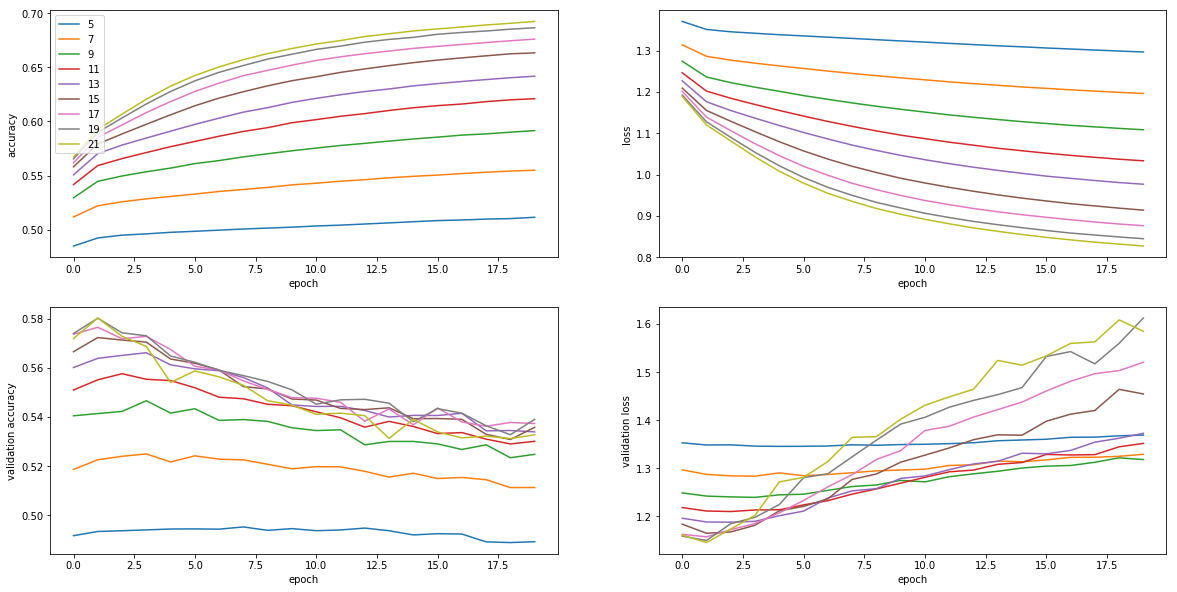

In [31]:
plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)

for chunk_size, model_results in model_results_per_chunk_size.items():
    plt.plot(model_results.history['acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([n for n, _ in model_results_per_chunk_size.items()], loc='upper left')

plt.subplot(2, 2, 2)

for chunk_size, model_results in model_results_per_chunk_size.items():
    plt.plot(model_results.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)

for chunk_size, model_results in model_results_per_chunk_size.items():
#     plt.plot(model_results.history['acc'])
    plt.plot(model_results.history['val_acc'])
plt.ylabel('validation accuracy')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)

for chunk_size, model_results in model_results_per_chunk_size.items():
#     plt.plot(model_results.history['loss'])
    plt.plot(model_results.history['val_loss'])
plt.ylabel('validation loss')
plt.xlabel('epoch')

plt.savefig('data/models_chunked_.png', dpi=300)
plt.show()

### Try most resonable size - 9

In [86]:
chunk_size = 9

x_train_chunked, y_train_chunked = input_to_chunks(x_train, y_train, chunk_size)
x_val_chunked, y_val_chunked = input_to_chunks(x_val, y_val, chunk_size)

x_train_chunked = np.argmax(x_train_chunked, axis=2)
x_val_chunked = np.argmax(x_val_chunked, axis=2)

x_input = Input(shape=(chunk_size,))
embed = Embedding(22, 9)(x_input)
conv1d_1 = Conv1D(filters=80, kernel_size=7, strides=1, padding='same', activation='relu')(embed)
conv1d_2 = Conv1D(filters=80, kernel_size=9, strides=1, padding='same', activation='relu')(conv1d_1)
add_2 = Add()([conv1d_1, conv1d_2])
conv1d_3 = Conv1D(filters=80, kernel_size=11, strides=1, padding='same', activation='relu')(add_2)
add_3 = Add()([add_2, conv1d_3])
flatten = Flatten()(add_3)
dense = Dense(9, activation='softmax')(flatten)
model = Model(x_input, dense)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

results = model.fit(x_train_chunked, y_train_chunked, batch_size=256, epochs=100, shuffle=True,
                    validation_data=(x_val_chunked, y_val_chunked))

100%|██████████| 261/261 [00:01<00:00, 241.37it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 9)            0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 9, 9)         198         input_43[0][0]                   
__________________________________________________________________________________________________
conv1d_107 (Conv1D)             (None, 9, 80)        5120        embedding_29[0][0]               
__________________________________________________________________________________________________
conv1d_108 (Conv1D)             (None, 9, 80)        57680       conv1d_107[0][0]                 
__________________________________________________________________________________________________
add_53 (Ad

Epoch 97/100
1168149/1168149 [==============================] - 41s 35us/step - loss: 1.0326 - acc: 0.6190 - val_loss: 1.4478 - val_acc: 0.5013
Epoch 98/100
1168149/1168149 [==============================] - 41s 35us/step - loss: 1.0319 - acc: 0.6192 - val_loss: 1.4457 - val_acc: 0.5049
Epoch 99/100
1168149/1168149 [==============================] - 41s 35us/step - loss: 1.0321 - acc: 0.6193 - val_loss: 1.4448 - val_acc: 0.5040
Epoch 100/100
1168149/1168149 [==============================] - 41s 35us/step - loss: 1.0313 - acc: 0.6197 - val_loss: 1.4518 - val_acc: 0.5028


In [76]:
y_train_chunked.shape

(1168149, 9)